<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/v0/shot0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# workflow notebook

Used reference:
-  [git in colab](https://www.geeksforgeeks.org/how-to-install-and-use-git-in-google-colab/)!

# 0. Open ipynb from github
To get this latest notebook from our repo into colab:
> "Open in colab" button == {Download from github} + {Upload to colab} - {Gets saved to drive}

# 1. Set up project in runtime
The following cell runs git config, clones the repo to get datasets as runtime files, and cds into project directory.

In [46]:
%pwd

'/content/CPSC-440-Project'

`git clone` seems too good to be true for getting a few GB of data into runtime, but `/datasets/` is up once clone is run! See:

In [6]:
import os
path = '/content/CPSC-440-Project/datasets/smallset_onesize/color'
files = os.listdir(path)
print(files)

['1676.jpg', '6680.jpg', '1977.jpg', '4539.jpg', '5361.jpg', '1987.jpg', '3261.jpg', '4201.jpg', '23.jpg', '5653.jpg', '4278.jpg', '3633.jpg', '1207.jpg', '2509.jpg', '967.jpg', '3850.jpg', '4459.jpg', '2216.jpg', '6701.jpg', '4904.jpg', '5119.jpg', '6983.jpg', '2185.jpg', '1723.jpg', '464.jpg', '5514.jpg', '6299.jpg', '4039.jpg', '4318.jpg', '7058.jpg', '5942.jpg', '3770.jpg', '4940.jpg', '6623.jpg', '2122.jpg', '4541.jpg', '2927.jpg', '3057.jpg', '2922.jpg', '5812.jpg', '6916.jpg', '1418.jpg', '4787.jpg', '6261.jpg', '5913.jpg', '1212.jpg', '1273.jpg', '5577.jpg', '554.jpg', '565.jpg', '2797.jpg', '4096.jpg', '4797.jpg', '330.jpg', '944.jpg', '682.jpg', '2452.jpg', '4449.jpg', '5991.jpg', '769.jpg', '5544.jpg', '1615.jpg', '1254.jpg', '3712.jpg', '1761.jpg', '3515.jpg', '2179.jpg', '5379.jpg', '2407.jpg', '725.jpg', '4474.jpg', '2476.jpg', '4937.jpg', '5452.jpg', '2161.jpg', '5519.jpg', '4134.jpg', '771.jpg', '21.jpg', '4921.jpg', '3148.jpg', '451.jpg', '1202.jpg', '6190.jpg', '3907.

# 2. Preprocess data

Datasets:
- `smallset_onesize`
  - Downloaded as is, [here](https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization).
  - 7130 color/gray pairs
  - Res 150x150
  - 0.232GB

In [7]:
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
import cv2 as cv


''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  arr = []
  for i in tqdm(files):
    img = cv.imread(path + '/'+i,1)
    img = img.astype('float32') / 255.0
    arr.append(img_to_array(img))

  return arr


In [8]:
color_arr = make_image_arr('/content/CPSC-440-Project/datasets/smallset_onesize/color')

100%|██████████| 7129/7129 [00:06<00:00, 1051.24it/s]


In [9]:
gray_arr = make_image_arr('/content/CPSC-440-Project/datasets/smallset_onesize/gray')

100%|██████████| 7129/7129 [00:05<00:00, 1255.85it/s]


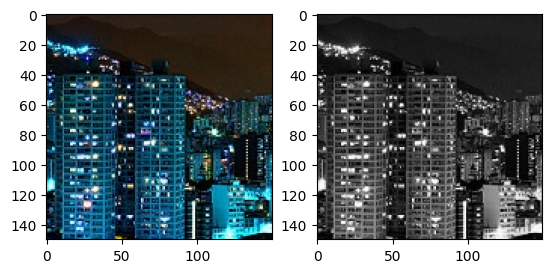

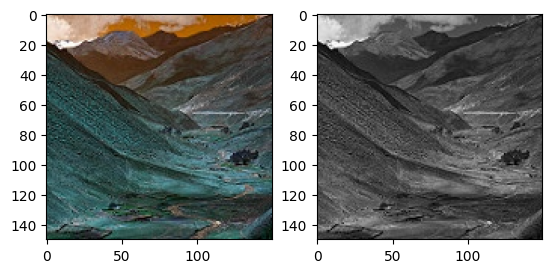

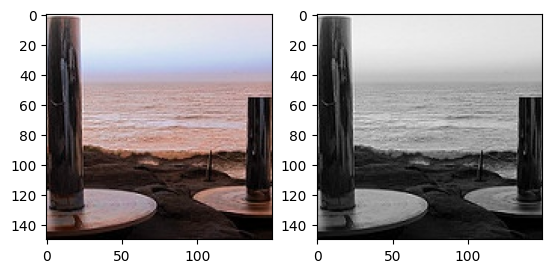

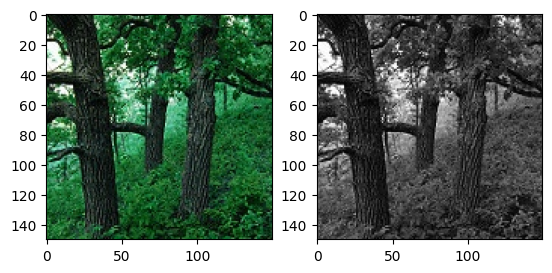

In [10]:
import matplotlib.pyplot as plt
import numpy as np

for i in np.random.randint(len(color_arr),size=4):
  plt.subplot(1,2,1)
  plt.imshow(color_arr[i])
  plt.subplot(1,2,2)
  plt.imshow(gray_arr[i])
  plt.show()

# 3. Saving new model weights to project directory

Toy model generated below:

- does not take our shapes (generator give it `image = torch.randn(1, 3, 224, 224)` :P)
- untrainable but just save it

In [11]:
# prompt: pytorch colourization autoencoder

import torch
import torch.nn as nn
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
# Create the autoencoder
autoencoder = Autoencoder()



input.shape (150, 150, 3)


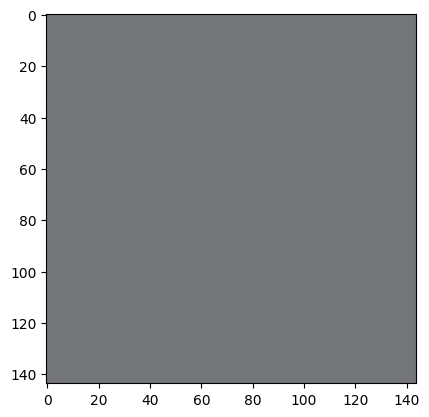

In [47]:
# Load the image
image = gray_arr[0]
print(f'input.shape {image.shape}')
# Colorize the image
t = torch.from_numpy(np.moveaxis(image, [2, 1], [0,2]))
colorized_image = autoencoder(t)
colorized_image_format = np.moveaxis(colorized_image.detach().numpy(), [1,2], [0,1])
plt.imshow(colorized_image_format)

#Shows the axis swap is correct process:
#plt.imshow(np.moveaxis(np.moveaxis(image, [2,1], [0,2]), [1,2], [0,1]))

In [48]:
torch.save(autoencoder.decoder,'/content/CPSC-440-Project/v0/decoder_weights')

# 4. Push changes

Look for any changes in the project directory, excluding this notebook, and push them.


In [53]:
!git add .

In [54]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   v0/decoder_weights



In [ ]:
!git commit -m "Message here"

In [ ]:
!git push

# 5. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!